<a href="https://colab.research.google.com/github/Ri796/Handwritten-digit-recognition/blob/main/Handwritten-digit-recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
print("PyTorch version:", torch.__version__)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


PyTorch version: 2.9.0+cpu
Device: cpu


In [3]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt

# MNIST pixels(0-255)... mean is 33.31 and sd is 78.57
Transform= transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

final_dataset= datasets.MNIST(root='data', train=True, download=True, transform=Transform)
print("size of the final_dataset",len(final_dataset))



#splitting the dataset in 3:2 ratio
total_size= len(final_dataset)
train_size= int(total_size*0.6)
test_size= total_size-train_size
train_dataset, test_dataset= random_split(final_dataset, [train_size, test_size])
print("size of the train_dataset",len(train_dataset))
print("size of the test_dataset",len(test_dataset))



batch_size=64
train_loader= DataLoader(train_dataset, batch_size, shuffle=True)
test_loader= DataLoader(test_dataset, batch_size, shuffle=False)

100%|██████████| 9.91M/9.91M [00:00<00:00, 61.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 3.34MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 15.3MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 10.9MB/s]


size of the final_dataset 60000
size of the train_dataset 36000
size of the test_dataset 24000


In [4]:
batch_imgs, batch_labels = next(iter(train_loader))
print("Batch imgs shape:", batch_imgs.shape)   # [B, C, H, W]
print("Batch labels shape:", batch_labels.shape)


Batch imgs shape: torch.Size([64, 1, 28, 28])
Batch labels shape: torch.Size([64])


In [5]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
  def __init__(self):
    super().__init__()

    self.conv1=nn.Conv2d(1,32, kernel_size=3)
    self.conv2=nn.Conv2d(32,64, kernel_size=3)
    self.conv3=nn.Conv2d(64,128, kernel_size=3)
    self.pool=nn.MaxPool2d(kernel_size=2, stride=2)
    self.fc1=nn.Linear(128*1*1,128)
    self.fc2=nn.Linear(128,10)


  def forward(self,x):
    x=F.relu(self.conv1(x))
    x=self.pool(x)
    x=F.relu(self.conv2(x))
    x=self.pool(x)
    x=F.relu(self.conv3(x))
    x=self.pool(x)
    x = x.view(x.size(0), -1)
    x=F.relu(self.fc1(x))
    x=self.fc2(x)
    return x

model=CNN().to(device)
print(model)

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=128, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [6]:
import torch.optim as optim

loss_fn=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(), lr=0.001)

In [7]:
def one_epoch(model, loader):
    model.train() #training mode
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)

        #zero the parameter gradients
        optimizer.zero_grad()

        #Forward pass
        outputs = model(images)
        loss = loss_fn(outputs, labels)

        #Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

        #Calculate accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_samples += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

    epoch_loss = running_loss / total_samples
    epoch_accuracy = (correct_predictions / total_samples) * 100

    print(f'Training Loss: {epoch_loss:.4f}, Training Accuracy: {epoch_accuracy:.2f}%')
    return epoch_loss, epoch_accuracy

In [8]:
EPOCHS = 10
for epoch in range(EPOCHS):
    train_loss, train_acc = one_epoch(model, train_loader)
    print(f"Epoch {epoch+1}:  Loss={train_loss:.4f},  Accuracy={train_acc:.4f}")


Training Loss: 0.2893, Training Accuracy: 90.99%
Epoch 1:  Loss=0.2893,  Accuracy=90.9861
Training Loss: 0.0903, Training Accuracy: 97.22%
Epoch 2:  Loss=0.0903,  Accuracy=97.2222
Training Loss: 0.0614, Training Accuracy: 98.08%
Epoch 3:  Loss=0.0614,  Accuracy=98.0806
Training Loss: 0.0510, Training Accuracy: 98.32%
Epoch 4:  Loss=0.0510,  Accuracy=98.3250
Training Loss: 0.0373, Training Accuracy: 98.81%
Epoch 5:  Loss=0.0373,  Accuracy=98.8139
Training Loss: 0.0309, Training Accuracy: 99.03%
Epoch 6:  Loss=0.0309,  Accuracy=99.0333
Training Loss: 0.0247, Training Accuracy: 99.23%
Epoch 7:  Loss=0.0247,  Accuracy=99.2278
Training Loss: 0.0214, Training Accuracy: 99.32%
Epoch 8:  Loss=0.0214,  Accuracy=99.3167
Training Loss: 0.0186, Training Accuracy: 99.39%
Epoch 9:  Loss=0.0186,  Accuracy=99.3861
Training Loss: 0.0163, Training Accuracy: 99.45%
Epoch 10:  Loss=0.0163,  Accuracy=99.4528


In [32]:

torch.save(model.state_dict(), 'mnist_cnn_model.pth')



In [10]:
from google.colab import drive
drive.mount('/content/drive')
torch.save(model.state_dict(), "/content/drive/MyDrive/mnist_cnn_model.pth")

Mounted at /content/drive


In [34]:
from sklearn.metrics import confusion_matrix

def test_checker(model, loader):
    model.eval()  #evaluation mode
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    y_true = []
    y_pred = []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)

            #Forward pass
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            running_loss += loss.item() * images.size(0)

            #Calculating all metrices
            predicted = outputs.argmax(dim=1)
            total_samples += labels.size(0)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    y_true=np.array(y_true)
    y_pred=np.array(y_pred)

    cm=confusion_matrix(y_true, y_pred)

    # Accuracy
    accuracy = np.trace(cm) / np.sum(cm) * 100

    # Class-wise Accuracy (same as Recall)
    classwise_accuracy = np.diag(cm) / np.sum(cm, axis=1) * 100
    recall = classwise_accuracy # Explicitly define recall here

    # Precision
    precision = np.diag(cm) / np.sum(cm, axis=0) * 100

    test_loss = running_loss / total_samples

    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {accuracy:.2f}%')


    print("Digitwise Metrics:")
    for i in range(10):
        print(
            f"Digit {i}: "
            f"Classwise Accuracy = {classwise_accuracy[i]:.2f}% | "
            f"Recall = {recall[i]:.2f}% | "
            f"Precision = {precision[i]:.2f}%"
        )

    return cm, classwise_accuracy, recall, precision, test_loss, accuracy

In [30]:

cm, classwise_accuracy, recall, precision, test_loss, accuracy = test_checker(model, test_loader)

Test Loss: 0.0634, Test Accuracy: 98.47%
Digitwise Metrics:
Digit 0: Classwise Accuracy = 99.44% | Recall = 99.44% | Precision = 98.31%
Digit 1: Classwise Accuracy = 99.48% | Recall = 99.48% | Precision = 99.26%
Digit 2: Classwise Accuracy = 98.67% | Recall = 98.67% | Precision = 97.53%
Digit 3: Classwise Accuracy = 98.16% | Recall = 98.16% | Precision = 99.63%
Digit 4: Classwise Accuracy = 98.73% | Recall = 98.73% | Precision = 97.58%
Digit 5: Classwise Accuracy = 97.92% | Recall = 97.92% | Precision = 99.25%
Digit 6: Classwise Accuracy = 97.23% | Recall = 97.23% | Precision = 99.39%
Digit 7: Classwise Accuracy = 98.30% | Recall = 98.30% | Precision = 98.22%
Digit 8: Classwise Accuracy = 98.09% | Recall = 98.09% | Precision = 98.67%
Digit 9: Classwise Accuracy = 98.48% | Recall = 98.48% | Precision = 96.89%


In [35]:

print(cm)


[[2324    0    1    0    0    1    2    1    0    8]
 [   0 2695    3    0    0    2    0    7    2    0]
 [   6    1 2292    1    2    0    1    7   11    2]
 [   2    2   18 2398    1    7    0    7    4    4]
 [   1    2    1    0 2341    0    2    5    2   17]
 [   5    1    0    4    3 2116    4    1    5   22]
 [  18    5    1    0   34    2 2283    0    4    1]
 [   0    5   29    3    2    0    0 2479    0    4]
 [   6    2    5    0    3    4    5    1 2306   19]
 [   2    2    0    1   13    0    0   16    3 2398]]


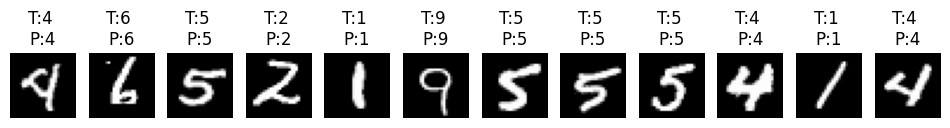

In [31]:
import matplotlib.pyplot as plt
import torch


dataiter = iter(test_loader)
images, labels = next(dataiter)


images, labels = images.to(device), labels.to(device)

model.eval()
with torch.no_grad():
    outputs = model(images)
    _, preds = torch.max(outputs, 1)

plt.figure(figsize=(12,3))
for i in range(12):
    img_disp = images[i].squeeze().cpu() * 0.3081 + 0.1307  #denormalize
    plt.subplot(1,12,i+1)
    plt.imshow(img_disp, cmap='gray')
    plt.title(f"T:{labels[i].item()} \nP:{preds[i].item()}")
    plt.axis('off')
plt.show()